# Анализ рынка игр 

**Описание:** Проект по выявлению закономерностей, определяющих успешность компьютерной игры. Данные получены из открытых источников (продажи игр, оценки пользователей и экспертов, жанры и игровые платформы). Данные до 2016 года. Планируется рекламная кампания на 2017-й. Описание данные в приложенном файле *data_info.txt*

**Задача:** выявить определяющие успешность игры закономерности

**Цель:** сделать ставку на потенциально популярный продукт, чтобы спланировать дальнейшие рекламные кампании.

**Пояснения:**
Аббревиатура ESRB (Entertainment Software Rating Board) — ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Ход исследования:**  
1. Изучение данных;
2. Подготовка и предобрабокта данных;
3. Исследовательский анализ данных;
4. Портрет пользователя каждого регионы;
5. Проверка гипотез;
6. Выводы, рекомендации.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')

## Изучение данных

In [2]:
try:
    df = pd.read_csv(r'C:\Users\artfo\Documents\yandex_practicum\projects\5_integrated_project_games\games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.isna().sum() #пропуски

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
#проверим какой тип нужен в столбце "critic_score"
df['critic_score_check'] = (df.Critic_Score * 100 % 100) > 0
if df.critic_score_check.unique() == False:
    print('Привести к целочисленному формату')
else:
    print('Оставить формат с плавающей точкой')
del df['critic_score_check'] #удалим служебный столбец

Привести к целочисленному формату


### Вывод

На этапе предобработки данных необходимо исправить следующие проблемы в данных:

* Верблюжий регистр в названии столбцов
* Исседовать и обработать пропуски 
* Привести данные к верными типам:
    * `year_of_release`, `critic_score`, `user_score` к `int` (предварительно нормализовав к `critic_score`)
* Также на следующем этапе подготовки данных посчитаем суммарные продажи во всех регионах

## Подготовка данных

In [7]:
df.columns = df.columns.str.lower()
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [8]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

### Обработка пропусков

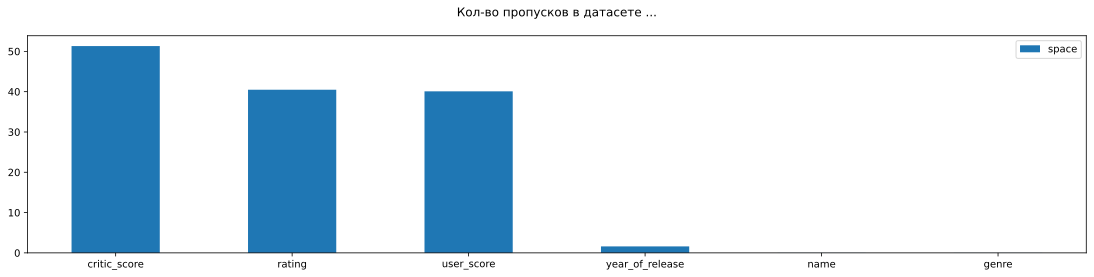

In [9]:
def pass_value(df): # пропущенные значения бары
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = False)
        .plot(kind= 'bar', figsize=(19,4), rot=0)
        .set_title('Кол-во пропусков в датасете ...' + '\n')
    );
pass_value(df)

In [10]:
df[df.name.isna()] #игры с пропусками в имени

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

In [11]:
df.query('platform == "GEN"') # посмотрим на все игры этой платформы

name platform  \
145                                 Sonic the Hedgehog 2      GEN   
257                                   Sonic the Hedgehog      GEN   
564                                        Mortal Kombat      GEN   
588                                      Streets of Rage      GEN   
659                                                  NaN      GEN   
832                                              NBA Jam      GEN   
960                                     Sonic & Knuckles      GEN   
996                                 Sonic the Hedgehog 3      GEN   
1099        Street Fighter II': Special Champion Edition      GEN   
1365                              Disney's The Lion King      GEN   
1453                                     Mortal Kombat 3      GEN   
1842                          NBA Jam Tournament Edition      GEN   
6451                                       Virtua Racing      GEN   
7885                                    Shining Force II      GEN   
8893                             Super Street Fighter II      GEN   
9000      Lunar 2: Eternal Blue(sales, but wrong system)      GEN   
9563                                      Gunstar Heroes      GEN   
9787                                    Ecco the Dolphin      GEN   
11563                   Yuu Yuu Hakusho: Makyo Toitsusen      GEN   
11660                Dragon Slayer: The Legend of Heroes      GEN   
11986                            Ecco: The Tides of Time      GEN   
12098  Street Fighter II': Special Champion Edition (...      GEN   
12264                                  Streets of Rage 3      GEN   
12984                                    Dynamite Headdy      GEN   
13343                                       Beyond Oasis      GEN   
14085                             J-League Pro Striker 2      GEN   
14132                             Castlevania Bloodlines      GEN   
14244                                                NaN      GEN   
14488                            Puzzle & Action: Tant-R      GEN   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
145             1992.0      Platform      4.47      1.20      0.16   
257             1991.0      Platform      3.03      0.91      0.26   
564             1992.0      Fighting      1.95      0.63      0.00   
588             1990.0        Action      1.86      0.55      0.11   
659             1993.0           NaN      1.78      0.53      0.00   
832             1992.0        Sports      1.75      0.25      0.00   
960             1994.0      Platform      1.24      0.43      0.03   
996             1994.0      Platform      1.02      0.47      0.20   
1099            1992.0      Fighting      1.00      0.30      0.31   
1365            1994.0      Platform      0.97      0.37      0.03   
1453            1994.0      Fighting      1.03      0.27      0.00   
1842            1994.0        Sports      0.95      0.14      0.00   
6451            1994.0        Racing      0.00      0.00      0.26   
7885            1993.0      Strategy      0.00      0.00      0.19   
8893            1993.0      Fighting      0.00      0.00      0.15   
9000            1994.0  Role-Playing      0.00      0.00      0.14   
9563            1992.0       Shooter      0.00      0.00      0.13   
9787            1992.0     Adventure      0.00      0.00      0.12   
11563           1994.0      Fighting      0.00      0.00      0.08   
11660           1994.0  Role-Playing      0.00      0.00      0.08   
11986           1993.0     Adventure      0.00      0.00      0.07   
12098           1993.0        Action      0.00      0.00      0.07   
12264           1993.0        Action      0.00      0.00      0.07   
12984           1993.0      Platform      0.00      0.00      0.05   
13343           1993.0  Role-Playing      0.00      0.00      0.05   
14085           1994.0        Sports      0.00      0.00      0.04   
14132           1994.0      Platform      0.00      0.00      0.04   
14244           1993.

По всем играм на платформе "GEN" отсутствуют данные со всеми рейтинговыми показателями, в двух строках с пропущенными именами также отсутствуют сведения о жанре, можем их удалить

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [13]:
df.dropna(subset=['name'], inplace=True) #check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [14]:
df[df.year_of_release.isna()] #check year_of_release missing values

name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP              NaN   
16405                      Freaky Flyers       GC              NaN   
16448                          Inversion       PC              NaN   
16458        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16522                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   
377          Sports      0.59      2.36      0.04         0.51          84.0   
456          Action      1.80      0.97      0.00         0.29          74.0   
475        Fighting      1.57      1.02      0.00         0.41           NaN   
609         Shooter      2.36      0.14      0.00         0.03           NaN   
...             ...       ...       ...       ...          ...           ...   
16373        Sports      0.01      0.00      0.00         0.00          43.0   
16405        Racing      0.01      0.00      0.00         0.00          69.0   
16448       Shooter      0.01      0.00      0.00         0.00          59.0   
16458     Adventure      0.01      0.00      0.00         0.00           NaN   
16522  Role-Playing      0.01      0.00      0.00         0.00          55.0   

      user_score rating  
183          8.5      E  
377          6.4      E  
456          7.9   E10+  
475          NaN    NaN  
609          NaN    NaN  
...          ...    ...  
16373        tbd   E10+  
16405        6.5      T  
16448        6.7      M  
16458        NaN    NaN  
16522        5.5      T  

[269 rows x 11 columns]

269 пропущенных значений в столбце `year_of_release` можем удалить.

In [15]:
df.dropna(subset=['year_of_release'], inplace=True)
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [16]:
df.critic_score.unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [17]:
df.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [18]:
df.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Итого у нас огромное количество NaN в столбцах
`critic_score` (8578),
`user_score` (6701),
`rating` (6766),
которые, однако, удалять мы также не можем, так как в строках присутствует необходимая информация о продажах. Но и заполнять такое большое количество `NaN` в числовых столбцах каким-либо приближенным значением может быть опасно для достоверности предстоящего анализа. Поэтому для удобства дальнейшего анализа заполним пропуски в столбцах `critic_score` и `user_score` отрицательными "заглушками".

In [19]:
df.fillna(-1, inplace=True)
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Замена значений

Помимо NaN в столбце `user_score` присутствуют значени `tbd`. Tbd - "*to be determined*". Это значит, что значения пока еще не определены и, возможно, будут определены в будущем

Для дальнейшего удобства подсчетов заменим значение tbd, как и пропуски - на 0, подразумевая, что рейтинг игр будет заполнен в будущем, после чего проведем необходимую типизацию. 

In [20]:
fill_condition = df.user_score == "tbd"
df['user_score'].where(~fill_condition, 0, inplace=True)
df.user_score.unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 0, '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [21]:
df.rating.unique()

array(['E', -1, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Значения в столбце `rating` - возрастная категория игр, которую присваивает организация "*Entertainment Software Rating Board*".

**«EC» («Early childhood») — «Для детей младшего возраста»**: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».

**«E» («Everyone») — «Для всех»**: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году. Первоначально "K-A" ("Kids to Adults")

**«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»**: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.

**«T» («Teen») — «Подросткам»**: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

**«M» («Mature») — «Для взрослых»**: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

**«AO» («Adults Only 18+») — «Только для взрослых»**: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. Большинство таких игр предназначено для персональных компьютеров под управлением Microsoft Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры. Первой игрой, которая получила данный рейтинг, стала The Joy of Sex, выпущенная в 1993 году.

**«RP» («Rating Pending») — «Рейтинг ожидается»**.

### Типизация и нормализация

In [22]:
df.year_of_release = df.year_of_release.astype('int') #типизация
df.critic_score = df.critic_score.astype('int')
df.user_score = (df.user_score.astype('float64') * 10).astype('int') #нормализация

In [23]:
display(df.head())
display(df.info())

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     28.96      3.77         8.45            76          80      E  
1      3.58      6.81         0.77            -1         -10     -1  
2     12.76      3.79         3.29            82          83      E  
3     10.93      3.28         2.95            80          80      E  
4      8.89     10.22         1.00            -1         -10     -1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int32  
 9   user_score       16444 non-null  int32  
 10  rating           16444 non-null  object 
dtypes: float64(4), int32(3), object(4)
memory usage: 1.3+ MB


None

### Суммарные продажи во всех регионах

In [24]:
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     28.96      3.77         8.45            76          80      E  
1      3.58      6.81         0.77            -1         -10     -1  
2     12.76      3.79         3.29            82          83      E  
3     10.93      3.28         2.95            80          80      E  
4      8.89     10.22         1.00            -1         -10     -1

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int32  
 9   user_score       16444 non-null  int32  
 10  rating           16444 non-null  object 
dtypes: float64(4), int32(3), object(4)
memory usage: 1.3+ MB


In [26]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45            76          80      E   
1      3.58      6.81         0.77            -1         -10     -1   
2     12.76      3.79         3.29            82          83      E   
3     10.93      3.28         2.95            80          80      E   
4      8.89     10.22         1.00            -1         -10     -1   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38

### Вывод

Мы обработали данные для последующего анализа:
* привели названия столбцов к змеиному регистру
* обнаружили пропуски, которые:
    * в столбце с годом удалили. Игры вышли в 1993 году, о причине пропусков ничего не известно, данных 
    * в столбцах с рейтингами решили не удалять, чтобы не потерять нужные данные о продажах
* заменили значение `tbd` (*to be determined*) в столбце `user_score` на NaN
* привели данные в столбцах `critic_score` и `user_score` к целочисленному формату
* посчитали продажи каждой игры по всем регионам

## Исследовательский анализ данных

### Как менялись продажи по платформам

Для начала проверим, сколько игр выпускалось в разные годы

In [27]:
games_per_year = df.pivot_table(index='year_of_release',
                                values='name',
                                aggfunc='count').reset_index()
sales_per_year = df.pivot_table(index='year_of_release',
                                values='total_sales',
                                aggfunc='sum').reset_index()
display(games_per_year.tail())
display(sales_per_year.tail())

year_of_release  name
32             2012   653
33             2013   544
34             2014   581
35             2015   606
36             2016   502

year_of_release  total_sales
32             2012       355.84
33             2013       361.24
34             2014       331.53
35             2015       267.98
36             2016       129.94

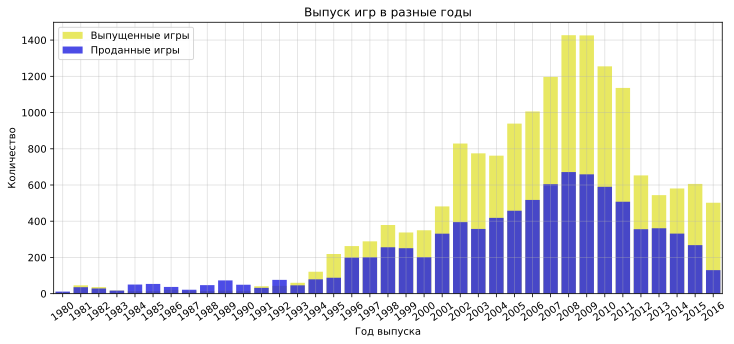

In [28]:
f, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x='year_of_release',
            y='name',
            data=games_per_year, 
            label='Выпущенные игры',
            color='yellow',
            alpha=.7)
sns.barplot(x='year_of_release',
            y='total_sales',
            data=sales_per_year,
            label='Проданные игры',
            color='blue',
            alpha=.8)
plt.xticks(rotation=35)
plt.legend(loc='upper left')
plt.grid(alpha=.4)
ax.set(xlabel='Год выпуска',
       ylabel='Количество',
       title='Выпуск игр в разные годы')
plt.show();

Видим, что пик продаж игр приходился на 2007 - 2011 годы. 

Теперь проанализируем продажи по разным платформам

In [29]:
sales_per_platform = df.pivot_table(index=['platform'], #суммарные продажи по платформам
                                    values=['total_sales'],
                                    aggfunc='sum').reset_index()
sales_per_platform.sort_values(by='total_sales', ascending=False)
top_sale_platforms = sales_per_platform.query('total_sales > 150') #платформы с максимальным значением суммарных продаж
top_sale_platforms = top_sale_platforms.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
top_sale_platforms

platform  total_sales
0       PS2      1233.56
1      X360       961.24
2       PS3       931.34
3       Wii       891.18
4        DS       802.78
5        PS       727.58
6       PS4       314.14
7       GBA       312.88
8       PSP       289.53
9       3DS       257.81
10       PC       255.76
11       GB       254.43
12       XB       251.57
13      NES       251.05
14      N64       218.01
15     SNES       200.04
16       GC       196.73
17     XOne       159.32

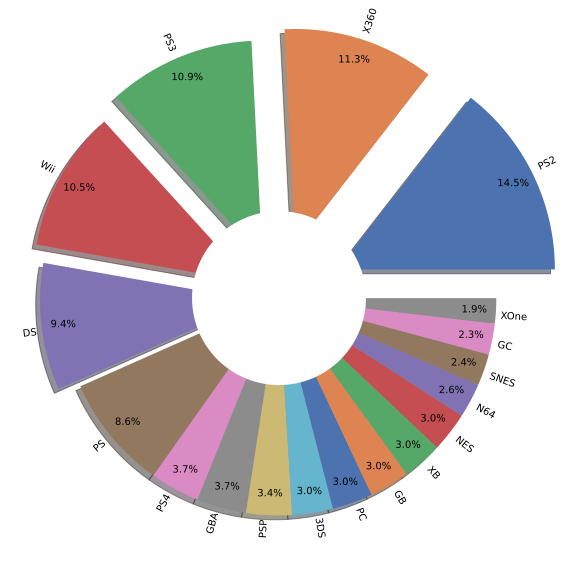

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
data = top_sale_platforms.total_sales
labels = top_sale_platforms.platform
colors = sns.color_palette('deep')
explode=(0.3, 0.25, 0.2, 0.15, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

plt.pie(data, labels=labels, colors=colors,
        labeldistance=1.02,
        rotatelabels=True,
        autopct='%.1f%%',
        pctdistance=0.9, 
        explode=explode,
        shadow=True)
centre_circle = plt.Circle((0, 0), 0.4, fc='white')
fig.gca().add_artist(centre_circle)
fig = plt.gcf()
plt.show();

Посмотрим как менялись с течением времени продажи по самым доходным платформам

In [31]:
platforms_by_year = df.query('platform in @top_sale_platforms.platform')

In [32]:
top_sale_platforms

platform  total_sales
0       PS2      1233.56
1      X360       961.24
2       PS3       931.34
3       Wii       891.18
4        DS       802.78
5        PS       727.58
6       PS4       314.14
7       GBA       312.88
8       PSP       289.53
9       3DS       257.81
10       PC       255.76
11       GB       254.43
12       XB       251.57
13      NES       251.05
14      N64       218.01
15     SNES       200.04
16       GC       196.73
17     XOne       159.32

In [33]:
#выделим платформы для визуализации
ps2 = platforms_by_year.query('platform == "PS2"')
x360 = platforms_by_year.query('platform == "X360"')
ps3 = platforms_by_year.query('platform == "PS3"')
wii = platforms_by_year.query('platform == "Wii"')
ds = platforms_by_year.query('platform == "DS"')
ps = platforms_by_year.query('platform == "PS"')
ps4 = platforms_by_year.query('platform == "PS4"')
gba = platforms_by_year.query('platform == "GBA"')
psp = platforms_by_year.query('platform == "PSP"')
ds3 = platforms_by_year.query('platform == "3DS"')
pc = platforms_by_year.query('platform == "PC"')
gb = platforms_by_year.query('platform == "GB"')
xb = platforms_by_year.query('platform == "XB"')
nes = platforms_by_year.query('platform == "NES"')
n64 = platforms_by_year.query('platform == "N64"')
snes = platforms_by_year.query('platform == "SNES"')
gc = platforms_by_year.query('platform == "GC"')
xone = platforms_by_year.query('platform == "XOne"')

Посмотрим, как менялись продажи по самым доходным платформам

In [34]:
#определим порядок визуализации для лучшего восприятия и удобства анализа
platform_timeline = (
df
    .groupby('platform')['year_of_release']
    .agg(['max', 'min'])
    .query('platform in @top_sale_platforms.platform')
    .sort_values(by='min', ascending=False)
)
platform_timeline

max   min
platform            
XOne      2016  2013
PS4       2016  2013
3DS       2016  2011
PS3       2016  2006
Wii       2016  2006
X360      2016  2005
PSP       2015  2004
GC        2007  2001
GBA       2007  2000
XB        2008  2000
PS2       2011  2000
N64       2002  1996
PS        2003  1994
SNES      1999  1990
GB        2001  1988
PC        2016  1985
DS        2013  1985
NES       1994  1983

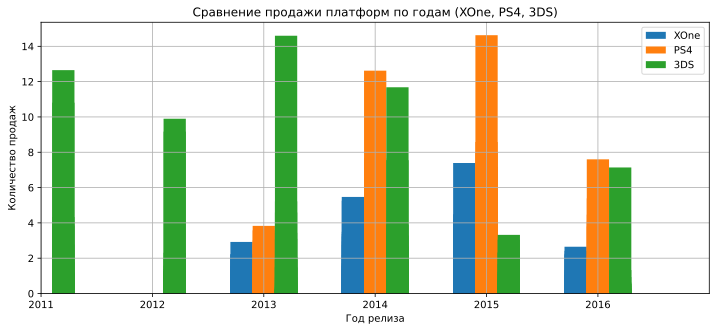

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(xone.year_of_release -0.2, xone.total_sales, width=0.2, label='XOne')
ax.bar(ps4.year_of_release, ps4.total_sales, width=0.2, label='PS4')
ax.bar(ds3.year_of_release + 0.2, ds3.total_sales, width=0.2, label='3DS')

plt.xlim(2011, 2017)
plt.xticks(np.arange(2011, 2017))
ax.legend(loc='best')
ax.set(xlabel='Год релиза',
       ylabel='Количество продаж',
       title="Сравнение продажи платформ по годам (XOne, PS4, 3DS)")
plt.grid()
plt.show();

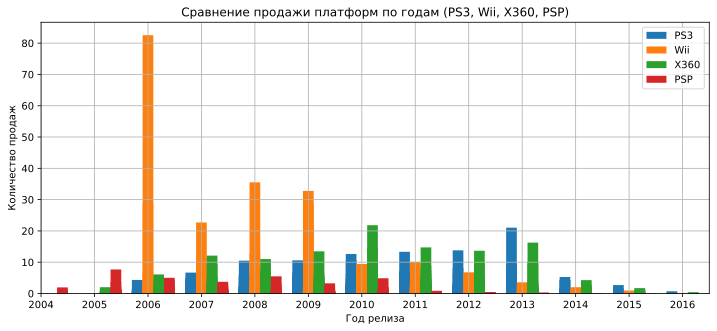

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(ps3.year_of_release - 0.2, ps3.total_sales, width=0.2, label='PS3')
ax.bar(wii.year_of_release, wii.total_sales, width=0.2, label='Wii')
ax.bar(x360.year_of_release + 0.2, x360.total_sales, width=0.2, label='X360')
ax.bar(psp.year_of_release + 0.4, psp.total_sales, width=0.2, label='PSP')

plt.xlim(2004, 2016.5)
plt.xticks(np.arange(2004, 2017))
ax.legend(loc='best')
ax.set(xlabel='Год релиза',
       ylabel='Количество продаж',
       title="Сравнение продажи платформ по годам (PS3, Wii, X360, PSP)")
plt.grid()
plt.show();

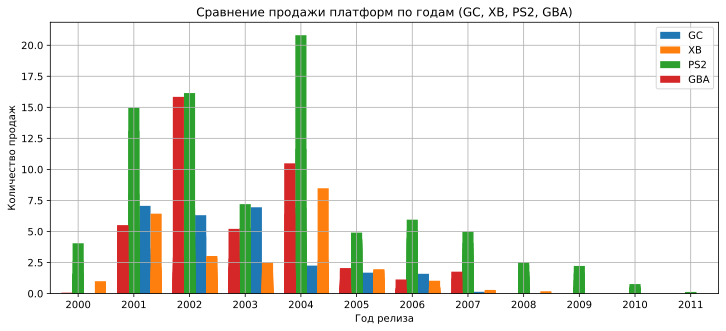

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(gc.year_of_release + 0.2, gc.total_sales, width=0.2, label='GC')
ax.bar(xb.year_of_release + 0.4, xb.total_sales, width=0.2, label='XB')
ax.bar(ps2.year_of_release, ps2.total_sales, width=0.2, label='PS2')
ax.bar(gba.year_of_release - 0.2, gba.total_sales, width=0.2, label='GBA')

plt.xlim(1999.5, 2011.5)
plt.xticks(np.arange(2000, 2012))
ax.legend(loc='best')
ax.set(xlabel='Год релиза',
       ylabel='Количество продаж',
       title="Сравнение продажи платформ по годам (GC, XB, PS2, GBA)")
plt.grid()
plt.show();

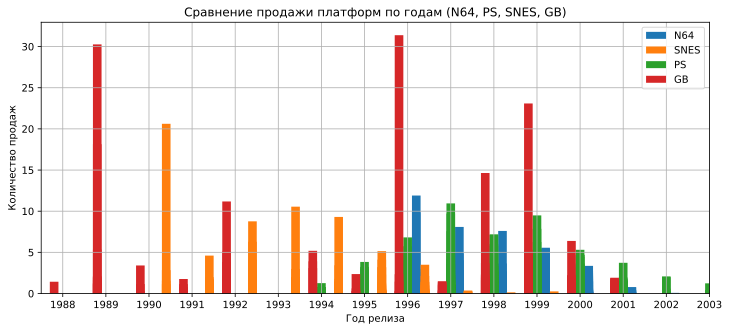

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(n64.year_of_release + 0.2, n64.total_sales, width=0.2, label='N64')
ax.bar(snes.year_of_release + 0.4, snes.total_sales, width=0.2, label='SNES')
ax.bar(ps.year_of_release, ps.total_sales, width=0.2, label='PS')
ax.bar(gb.year_of_release - 0.2, gb.total_sales, width=0.2, label='GB')

plt.xlim(1987.5, 2003)
plt.xticks(np.arange(1988, 2004))
ax.legend(loc='best')
ax.set(xlabel='Год релиза',
       ylabel='Количество продаж',
       title="Сравнение продажи платформ по годам (N64, PS, SNES, GB)")
plt.grid()
plt.show();

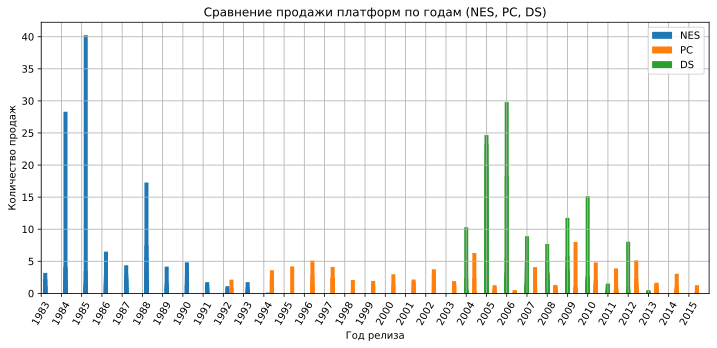

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(nes.year_of_release + 0.2, nes.total_sales, width=0.2, label='NES')
ax.bar(pc.year_of_release + 0.4, pc.total_sales, width=0.2, label='PC')
ax.bar(ds.year_of_release, ds.total_sales, width=0.2, label='DS')

plt.xlim(1983, 2016)
plt.xticks(np.arange(1983, 2016), rotation=60)
ax.legend(loc='best')
ax.set(xlabel='Год релиза',
       ylabel='Количество продаж',
       title="Сравнение продажи платформ по годам (NES, PC, DS)")
plt.grid()
plt.show();

Посчитаем, за какой характерный срок появляются новые и исчезают старые платформы

In [40]:
platform_timeline['lifetime'] = platform_timeline['max'] - platform_timeline['min']
platform_timeline.sort_values(by='lifetime', inplace=True, ascending=False)
platform_timeline

max   min  lifetime
platform                      
PC        2016  1985        31
DS        2013  1985        28
GB        2001  1988        13
NES       1994  1983        11
X360      2016  2005        11
PSP       2015  2004        11
PS2       2011  2000        11
PS3       2016  2006        10
Wii       2016  2006        10
PS        2003  1994         9
SNES      1999  1990         9
XB        2008  2000         8
GBA       2007  2000         7
N64       2002  1996         6
GC        2007  2001         6
3DS       2016  2011         5
PS4       2016  2013         3
XOne      2016  2013         3

In [41]:
#найдем среднее время жизни платформ
avg_platform_lifetime = platform_timeline.lifetime.median()
print()
print(f'Среднее время жизни платформы - {avg_platform_lifetime} лет')
print()


Среднее время жизни платформы - 9.5 лет



Так как среднее время жизни платформы составляет 9 лет 6 месяцев, а прогноз нам нужен на 2017, плюс в такой динамично меняющейся индустрии, как компьютерные игры слишком большой временной интервал будет нерелевантен - есть высокий риск захватить уже отжившие тренды. Но и очень короткий период не подходит для прогнозирования, так что выберем золотую середину - **5 лет, включая 2016 год.** 

In [42]:
df_act = df.query('year_of_release >= 2012')
df_act.reset_index(drop=True, inplace=True)
df_act

name platform  year_of_release         genre  \
0                Grand Theft Auto V      PS3             2013        Action   
1                Grand Theft Auto V     X360             2013        Action   
2         Call of Duty: Black Ops 3      PS4             2015       Shooter   
3               Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
4        Call of Duty: Black Ops II      PS3             2012       Shooter   
...                             ...      ...              ...           ...   
2881               Strawberry Nauts      PSV             2016     Adventure   
2882               Aiyoku no Eustia      PSV             2014          Misc   
2883  Samurai Warriors: Sanada Maru      PS3             2016        Action   
2884        Haitaka no Psychedelica      PSV             2016     Adventure   
2885            Winning Post 8 2016      PSV             2016    Simulation   

      na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0         7.02      9.09      0.98         3.96            97          82   
1         9.66      5.14      0.06         1.41            97          81   
2         6.03      5.86      0.36         2.38            -1         -10   
3         5.28      4.19      4.35         0.78            -1         -10   
4         4.99      5.73      0.65         2.42            83          53   
...        ...       ...       ...          ...           ...         ...   
2881      0.00      0.00      0.01         0.00            -1         -10   
2882      0.00      0.00      0.01         0.00            -1         -10   
2883      0.00      0.00      0.01         0.00            -1         -10   
2884      0.00      0.00      0.01         0.00            -1         -10   
2885      0.00      0.00      0.01         0.00            -1         -10   

     rating  total_sales  
0         M        21.05  
1         M        16.27  
2        -1        14.63  
3        -1        14.60  
4         M        13.79  
...     ...          ...  
2881     -1         0.01  
2882     -1         0.01  
2883     -1         0.01  
2884     -1         0.01  
2885     -1         0.01  

[2886 rows x 12 columns]

In [43]:
print(f'Актуальных платформ всего {df_act.platform.nunique()}, это: {", ".join(df_act.platform.unique())}')

Актуальных платформ всего 11, это: PS3, X360, PS4, 3DS, DS, XOne, WiiU, Wii, PC, PSV, PSP


### Потенциально прибыльные платформы

Взглянем на динамику продаж по каждой платформе

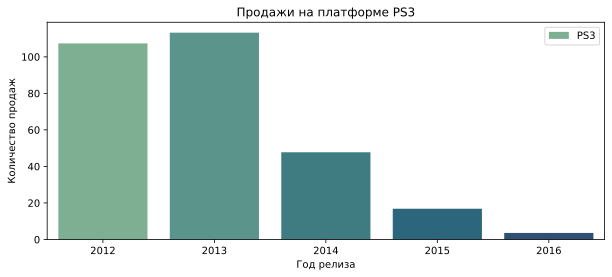

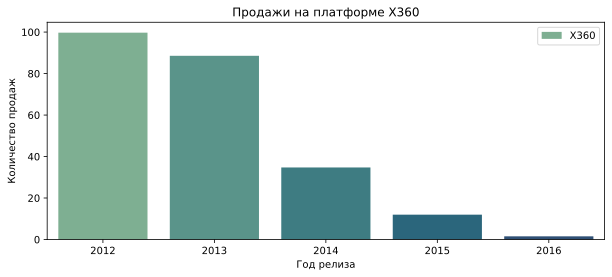

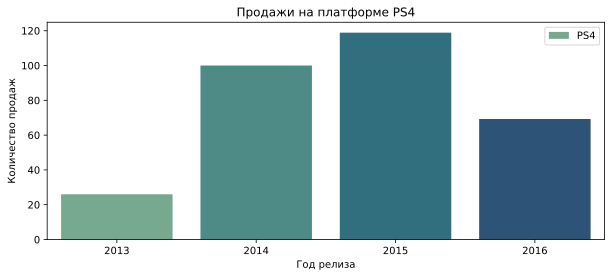

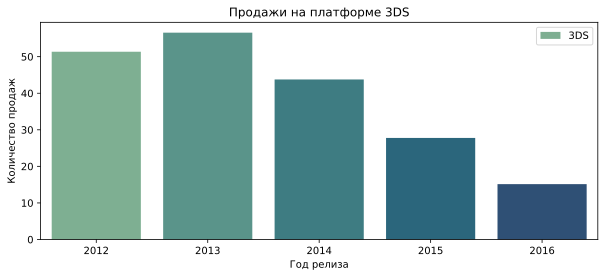

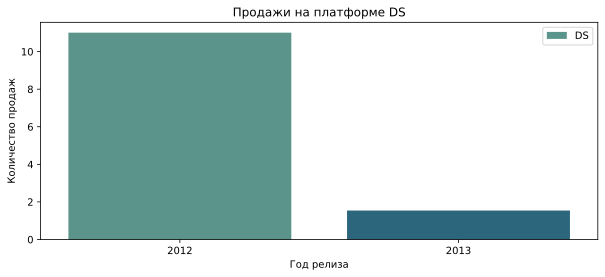

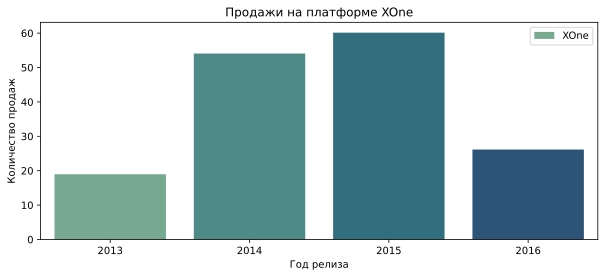

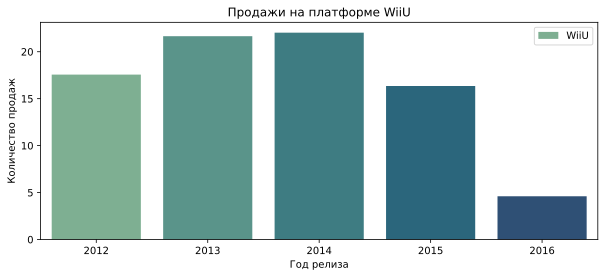

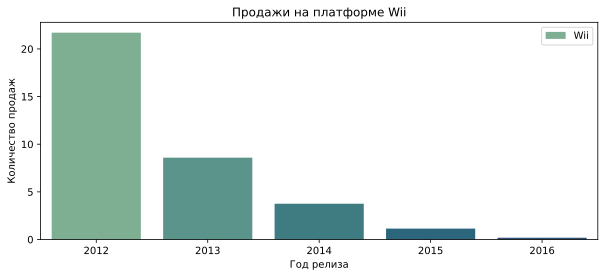

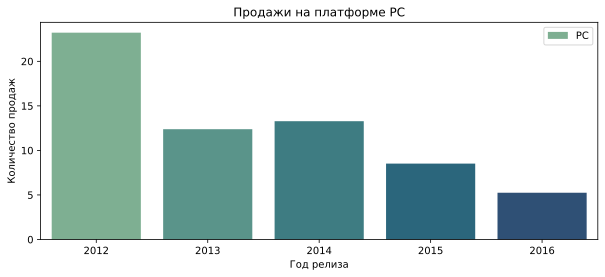

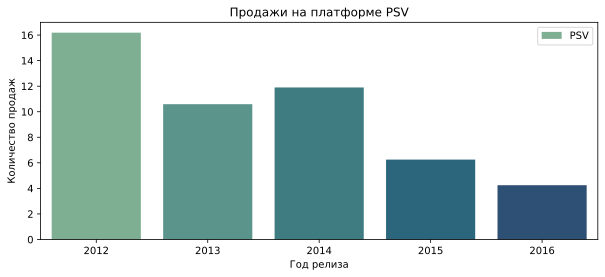

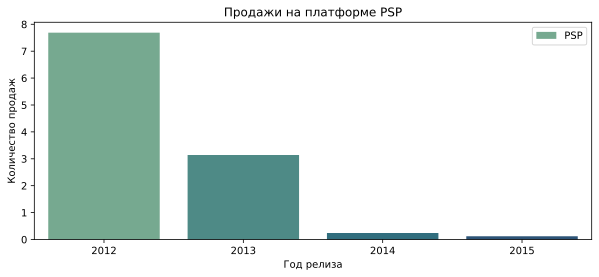

In [44]:
act_platform_sales = df_act.pivot_table(index=['platform', 'year_of_release'],
                                        values='total_sales',
                                        aggfunc='sum')
act_platform_sales.reset_index(inplace=True)
platform_analyzed = df_act.platform.unique()
for i in range(len(platform_analyzed)):
    fig, ax = plt.subplots(figsize=(10, 4))
    platform = platform_analyzed[i]
    platform_row = act_platform_sales.query('platform == @platform')
    sns.barplot(data=platform_row,
                x='year_of_release',
                y='total_sales',
                label=platform,
                palette='crest')
    ax.legend(loc='best')
    ax.set(xlabel='Год релиза',
           ylabel='Количество продаж',
           title='Продажи на платформе ' + platform)
    plt.show()

In [45]:
games_pivot = df_act.pivot_table(index=['platform', 'name'], #сводная таблица продаж по платформе и назавнию игры 
                                 values='total_sales',
                                 aggfunc='sum')
games_pivot.reset_index(inplace=True)
games_pivot.tail(10)

platform                        name  total_sales
2875     XOne                  Watch Dogs         1.57
2876     XOne                Watch Dogs 2         0.36
2877     XOne  Wolfenstein: The New Order         0.68
2878     XOne  Wolfenstein: The Old Blood         0.15
2879     XOne                  Worms: WMD         0.01
2880     XOne                      XCOM 2         0.04
2881     XOne                      ZombiU         0.01
2882     XOne         Zombie Army Trilogy         0.11
2883     XOne           Zoo Tycoon (2013)         0.36
2884     XOne  Zumba Fitness: World Party         0.24

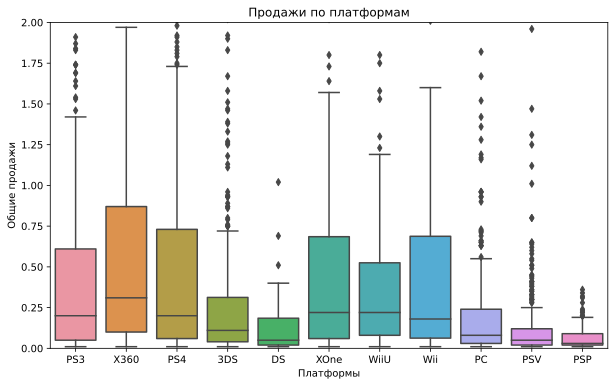

In [46]:
plt.figure(figsize=(10, 6))
(sns.boxplot(data = df_act, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2)))

plt.show()

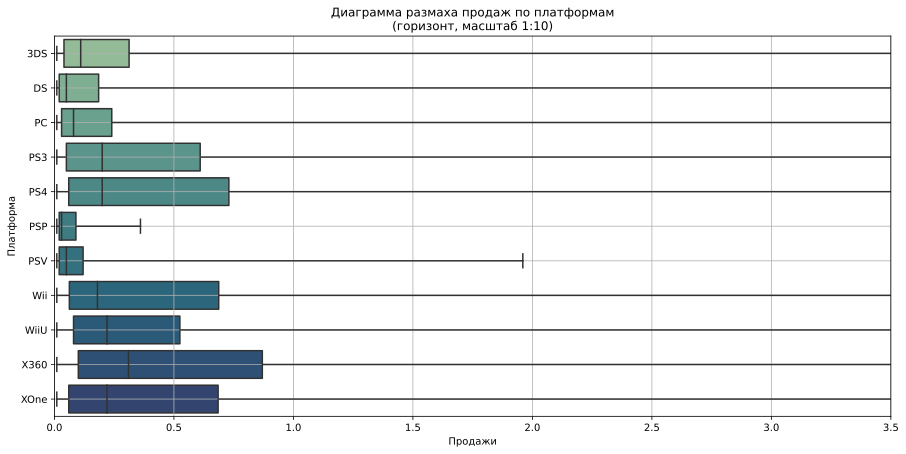

In [47]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=games_pivot,
            x='total_sales',
            y='platform',
            palette='crest',
            whis=[0,100])
ax.grid()
ax.set(xlabel='Продажи',
       ylabel='Платформа',
       title='Диаграмма размаха продаж по платформам\n(горизонт, масштаб 1:10)',
       xlim=(0, 3.5))
plt.show()

In [48]:
ps4_for_plotting = df_act.query('platform == "PS4" and user_score > 0 and critic_score > 0')[
    ['critic_score',
    'user_score',
    'total_sales']
]

xone_for_plotting = df_act.query('platform == "XOne" and user_score > 0 and critic_score > 0')[
    ['critic_score',
    'user_score',
    'total_sales']
]
display(ps4_for_plotting.tail())
display(xone_for_plotting.tail())

critic_score  user_score  total_sales
2797            42          23         0.01
2802            70          68         0.01
2803            69          75         0.01
2814            61          79         0.01
2815            51          55         0.01

critic_score  user_score  total_sales
2749            66          75         0.01
2770            53          63         0.01
2840            65          60         0.01
2854            63          82         0.01
2867            74          67         0.01

#### PS4

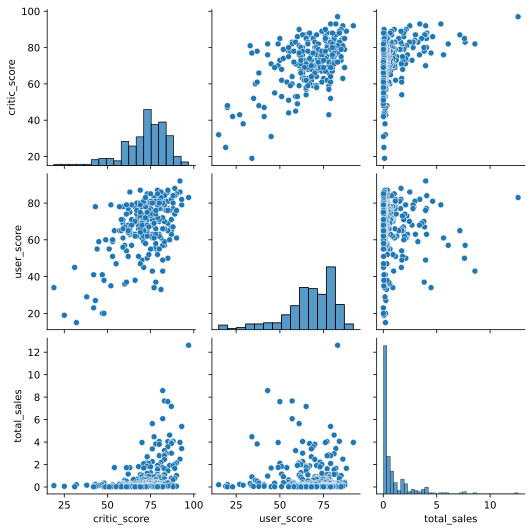

In [49]:
sns.pairplot(ps4_for_plotting);

In [50]:
ps4_corr = ps4_for_plotting.corr() #то же самое в цифрах
ps4_corr

critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.405895
user_score        0.557654    1.000000    -0.033625
total_sales       0.405895   -0.033625     1.000000

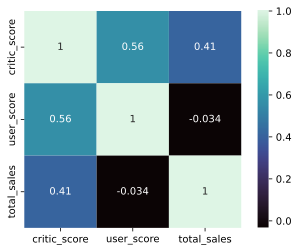

In [51]:
sns.heatmap(ps4_corr, #то же самое на тепловой карте
            annot=True,
            square=True,
            cmap='mako');

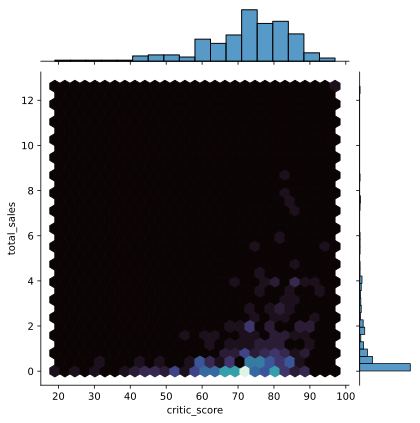

In [52]:
sns.jointplot('critic_score',
             'total_sales',
             data=ps4_for_plotting,
             kind='hex',
             cmap='mako');

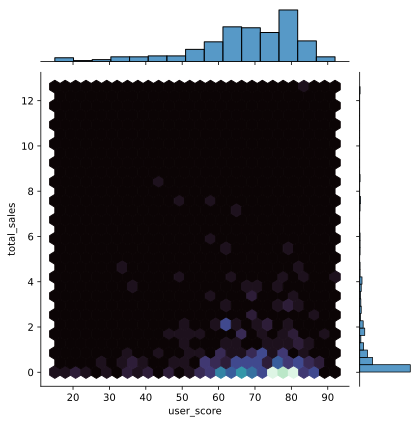

In [53]:
sns.jointplot('user_score',
             'total_sales',
             data=ps4_for_plotting,
             kind='hex',
             cmap='mako');

#### Xbox One

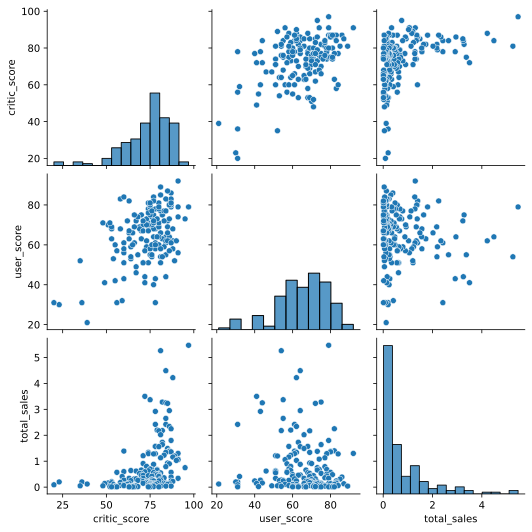

In [54]:
sns.pairplot(xone_for_plotting);

In [55]:
xone_corr = xone_for_plotting.corr()
xone_corr

critic_score  user_score  total_sales
critic_score      1.000000    0.472462     0.410422
user_score        0.472462    1.000000    -0.094003
total_sales       0.410422   -0.094003     1.000000

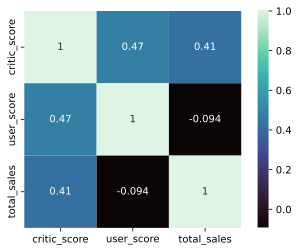

In [56]:
sns.heatmap(xone_corr,
            annot=True,
            square=True,
            cmap='mako');

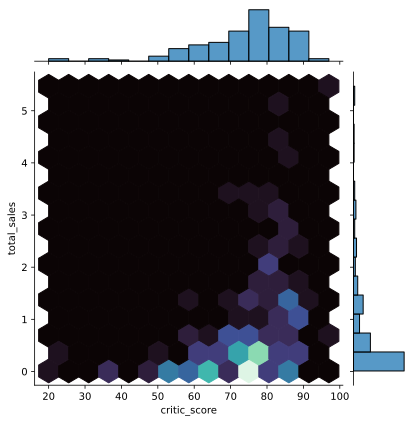

In [57]:
sns.jointplot('critic_score',
             'total_sales',
             data=xone_for_plotting.query('critic_score > 0'),
             kind='hex',
             cmap='mako');

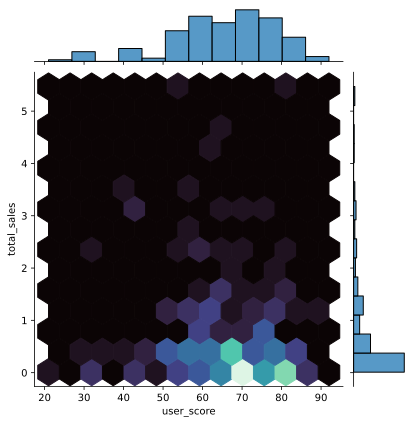

In [58]:
sns.jointplot('user_score',
             'total_sales',
             data=xone_for_plotting.query('user_score > 0'),
             kind='hex',
             cmap='mako');

Существует зависимость, хоть и довольно слабая между отзывами критиков и продажами, видно что у значительной части игр с большими продажами нормальные/хорошие отзывы. 
C оценками пользователей зависимость очень слабая, и на диаграмме рассеяния не отмечено тех или иных тенденций. 

Любопытно отметить, что оценки пользователей имеют умеренную корреляцию с оценками критиков. Иными слоавми в более, оценки пользователей имеют тенденцию совпадать с оценками критиков. 

### Распределение по жанрам

In [59]:
pivot_genre_total = df_act.pivot_table( #продажи по жанрам
    index='genre',
    columns='year_of_release',
    values='total_sales',
    aggfunc='sum').T
pivot_genre_total

genre            Action  Adventure  Fighting   Misc  Platform  Puzzle  Racing  \
year_of_release                                                                 
2012             119.25       5.79      9.18  22.22     18.37    1.72   13.61   
2013             122.51       6.09      7.09  25.27     24.54    0.96   12.37   
2014              97.23       5.57     15.85  23.38      8.81    1.49   16.66   
2015              72.02       8.16      7.90  11.57      6.05    0.71    8.07   
2016              30.11       3.82      4.47   2.60      3.23    0.01    2.79   

genre            Role-Playing  Shooter  Simulation  Sports  Strategy  
year_of_release                                                       
2012                    46.91    71.75       13.36   30.42      3.26  
2013                    44.45    62.04        8.63   41.17      6.12  
2014                    45.62    65.21        5.58   45.15      0.98  
2015                    37.64    67.51        5.66   40.84      1.85  
2016                    18.18    38.22        1.89   23.49      1.13

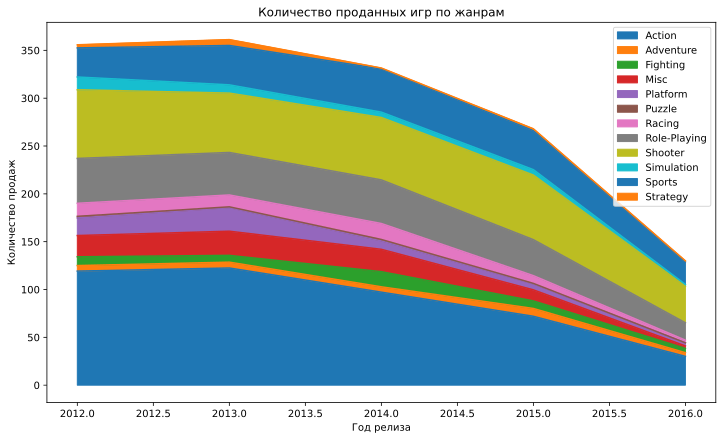

In [60]:
pivot_genre_total.plot(kind='area', figsize=(12, 7))
plt.title('Количество проданных игр по жанрам')
plt.xlabel('Год релиза')
plt.ylabel('Количество продаж')
plt.legend()
plt.show();

In [61]:
pivot_genre_median = df_act.pivot_table( #продажи по жанрам
    index='genre',
    columns='year_of_release',
    values='total_sales',
    aggfunc='median').T
pivot_genre_median

genre            Action  Adventure  Fighting   Misc  Platform  Puzzle  Racing  \
year_of_release                                                                 
2012              0.170      0.040     0.190  0.190     0.150   0.020   0.245   
2013              0.200      0.025     0.155  0.175     0.385   0.100   0.340   
2014              0.205      0.040     0.130  0.160     0.830   0.050   0.170   
2015              0.070      0.030     0.100  0.190     0.100   0.045   0.150   
2016              0.050      0.020     0.085  0.040     0.100   0.010   0.050   

genre            Role-Playing  Shooter  Simulation  Sports  Strategy  
year_of_release                                                       
2012                    0.180    0.415       0.195    0.28     0.090  
2013                    0.180    0.340       0.105    0.37     0.190  
2014                    0.110    0.660       0.120    0.46     0.060  
2015                    0.105    0.925       0.200    0.12     0.045  
2016                    0.120    0.240       0.025    0.12     0.060

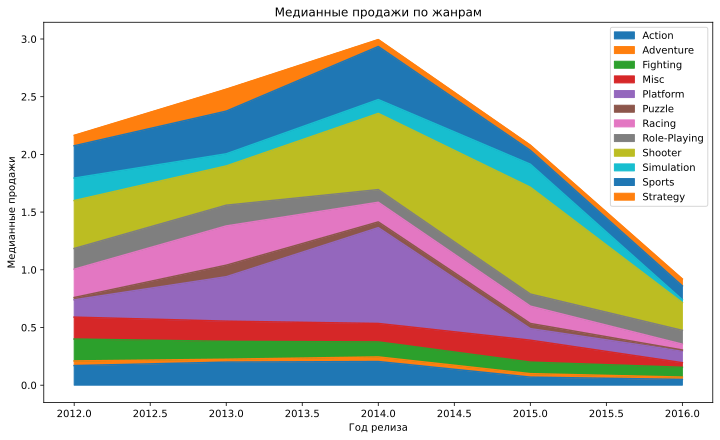

In [62]:
pivot_genre_median.plot(kind='area', figsize=(12, 7))
plt.title('Медианные продажи по жанрам')
plt.xlabel('Год релиза')
plt.ylabel('Медианные продажи')
plt.legend()
plt.show();

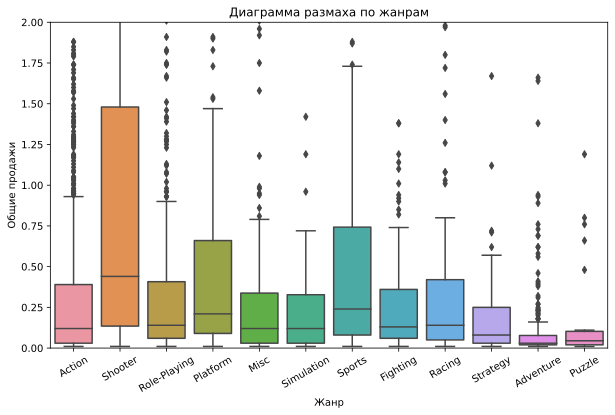

In [63]:
plt.figure(figsize=(10, 6))
(sns.boxplot(data = df_act, y = 'total_sales', x='genre')
    .set(title = 'Диаграмма размаха по жанрам', xlabel = 'Жанр', ylabel = 'Общие продажи', ylim=(0, 2)))
plt.xticks(rotation=30)
plt.show()

### Вывод

Проводя исследовательский анализ, мы вычислили среднее "время жизни" платформы, (в данном случае с помощью медианы из-за показателей ПК, время жизни которого нерелевантно), которое оказалось равно 9.5 годам. Соответственно мы отобрали игры 2008 года и младше.  
Из отобранных платформ самые низкие показатели игр к 2016 году показали:
* *XBox 360*, 
* *PS3*, 
* *Nintendo Wii*, 
* *Nintendo DS*.  

Наибольшый потцениал продаж - очевидно у современных платформ:   
* *PS4*,
* *Xbox One*.  

Наблюдается снижение продаж по:   
* *PSP*, 
* *WiiU*, 
* *3DS*  

и в свете выхода новых продолжат резонно снижаться.  

ПК к 2017 году сдал позиции как игровая платформа консолям, но по прежнему остается актульным.

Распределение на диаграмме размаха на всех платформах не сильно отличается, платормы *Wii, X360, PS3* имеет более высокий межквартильный размах, однако среднее значение количества продаж примерно такое же, как у прочих платформ.   

Самые популярные жанры по общему количеству продаж: 
* *Action*, 
* *Shooter*, 
* *Sports*,   

При анализе медианы продаж, довольно высокая доля видна также у жанра *platform*.

Самые непопулярные:
* *Strategy* 
* *Puzzle*

Крутая картинка и движуха для игровой индустрии на сегодняшний день имеет гораздо более выоский спрос, чем шевеление мозгами.  

Что касается корреляции данных, зависимость между пользовательским рейтингом и продажами почти полностью отсутствует. Однако есть корреляция между рейтингом от критиков и рейтингом от пользователей. 

## Портрет пользователя каждого региона

Для каждого из регионов (NA, EU, JP) определим:

* Самые популярные платформы (топ-5),
* Самые популярные жанры (топ-5),
* Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Самые популярные платформы

In [64]:
df_act.head()

name platform  year_of_release         genre  \
0          Grand Theft Auto V      PS3             2013        Action   
1          Grand Theft Auto V     X360             2013        Action   
2   Call of Duty: Black Ops 3      PS4             2015       Shooter   
3         Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
4  Call of Duty: Black Ops II      PS3             2012       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0      7.02      9.09      0.98         3.96            97          82      M   
1      9.66      5.14      0.06         1.41            97          81      M   
2      6.03      5.86      0.36         2.38            -1         -10     -1   
3      5.28      4.19      4.35         0.78            -1         -10     -1   
4      4.99      5.73      0.65         2.42            83          53      M   

   total_sales  
0        21.05  
1        16.27  
2        14.63  
3        14.60  
4        13.79

In [65]:
regions = {'Северная Америка': df_act.columns[4], 'Европа': df_act.columns[5], 'Япония': df_act.columns[6], 'Остальной мир': df_act.columns[7]}

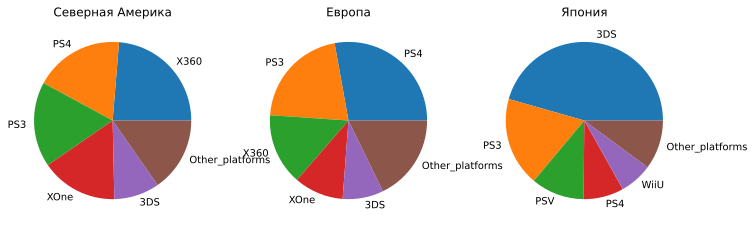

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

for i in range(3):
    #5 самых продающих платформ
    df_i = (df_act.groupby('platform')[list(regions.values())[i]].sum().
            reset_index().
            sort_values(list(regions.values())[i], ascending=False, ignore_index=True).
            head(5))
    #остальные продажи занесем в Other_platforms
    df_i = df_i.append({'platform': 'Other_platforms', list(regions.values())[i]: df_act[list(regions.values())[i]].sum() - df_i[list(regions.values())[i]].sum()}, ignore_index=True)
    ax[i].pie(df_i[list(regions.values())[i]], labels = df_i['platform'])
    
    ax[i].set_title(list(regions.keys())[i])

plt.show();

In [67]:
i = 0
pivot_popular_platforms = pd.DataFrame()
for region in regions:
    print(f"Топ-5 самых популярных платформ в регионе \"{list(regions.keys())[i]}\":")
    df_temp1 = df_act.groupby('platform')[regions[region]].sum().sort_values(ascending=False)[:5]
    df_temp2 = df_act.groupby('platform')[regions[region]].sum().sort_values(ascending=False)[6:]
    print(df_temp1)
    print()
    print('Остальные платформы')
    print(df_temp2)
    print()
    print('-' * 30, '\n')
    i += 1
    pivot_popular_platforms = pd.merge(pivot_popular_platforms, df_temp1, how='outer', left_index=True, right_index=True)

Топ-5 самых популярных платформ в регионе "Северная Америка":
platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

Остальные платформы
platform
PC     19.12
Wii    17.45
PSV    10.98
DS      4.59
PSP     0.13
Name: na_sales, dtype: float64

------------------------------ 

Топ-5 самых популярных платформ в регионе "Европа":
platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

Остальные платформы
platform
WiiU    25.13
Wii     11.92
PSV     11.36
DS       3.53
PSP      0.42
Name: eu_sales, dtype: float64

------------------------------ 

Топ-5 самых популярных платформ в регионе "Япония":
platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

Остальные платформы
platform
DS      3.72
Wii     3.39
X360    1.57
XOne    0.34
PC      0.00
Name: jp_sales, dtype: float64

------------------------------ 

Топ-5 сам

In [68]:
pivot_popular_platforms.fillna(0, inplace=True)
column_names = list(regions.keys())
pivot_popular_platforms.columns = column_names
pivot_popular_platforms

Северная Америка  Европа  Япония  Остальной мир
platform                                                 
3DS                  55.31   42.64   87.79           8.87
PS3                 103.38  106.86   35.29          43.26
PS4                 108.74  141.09   15.96          48.35
PSV                   0.00    0.00   21.04           0.00
WiiU                  0.00    0.00   13.01           0.00
X360                140.05   74.52    0.00          20.40
XOne                 93.12   51.59    0.00          14.27

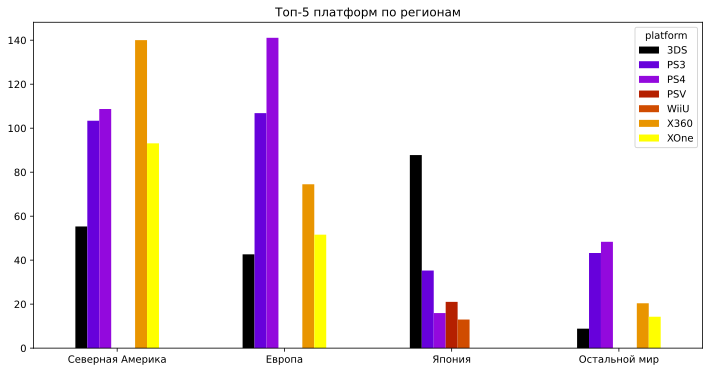

In [69]:
pivot_popular_platforms.T.plot(kind='bar',figsize=(12,6),colormap='gnuplot')
plt.title('Топ-5 платформ по регионам')
plt.xticks(rotation=0)
plt.show()

In [70]:
for_visual_platforms = df_act.pivot_table(values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], index='platform', aggfunc='sum')
for_visual_platforms.columns = ["Европа", "Япония", "Северная Америка", "Остальной мир"]
for_visual_platforms

Европа  Япония  Северная Америка  Остальной мир
platform                                                 
3DS        42.64   87.79             55.31           8.87
DS          3.53    3.72              4.59           0.71
PC         37.76    0.00             19.12           5.77
PS3       106.86   35.29            103.38          43.26
PS4       141.09   15.96            108.74          48.35
PSP         0.42   10.47              0.13           0.17
PSV        11.36   21.04             10.98           5.80
Wii        11.92    3.39             17.45           2.61
WiiU       25.13   13.01             38.10           5.95
X360       74.52    1.57            140.05          20.40
XOne       51.59    0.34             93.12          14.27

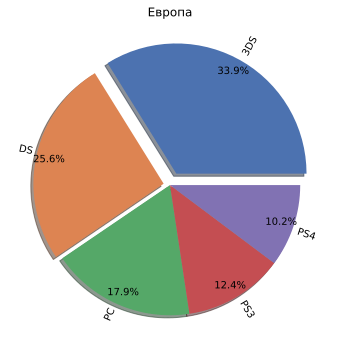

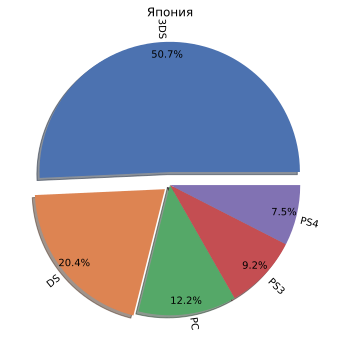

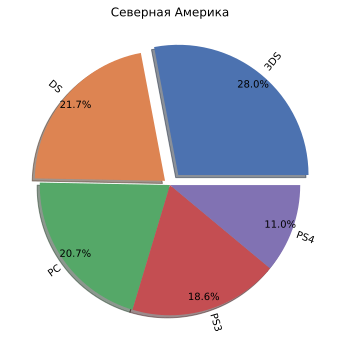

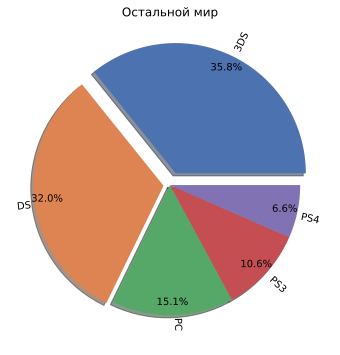

In [71]:
regions_analyzed = for_visual_platforms.columns.to_list()
for region in regions_analyzed:
    fig, ax = plt.subplots(figsize=(12, 6))
    data = for_visual_platforms[region].sort_values(ascending=False)[:5]
    labels = for_visual_platforms.index.to_list()[:5]
    colors = sns.color_palette('deep')
    explode=[0.1, 0.05, 0, 0, 0]
    

    plt.pie(data, labels=labels, colors=colors,
            labeldistance=1.02,
            rotatelabels=True,
            explode=explode,
            autopct='%.1f%%',
            pctdistance=0.9, 
            shadow=True)
    plt.title(region)
    plt.show();

### Самые популярные жанры

In [72]:
regions = {'Северная Америка': 'na_sales',
           'Европа': 'eu_sales',
           'Япония': 'jp_sales',
           'Остальной мир': 'other_sales'}
i = 0
pivot_popular_genres = pd.DataFrame()
for region in regions:
    print(f"Топ-5 самых популярных жанров в регионе \"{list(regions.keys())[i]}\":\n")
    
    df_temp = (df_act
    .groupby('genre')[regions[region]]
    .sum()
    .sort_values(ascending=False)[:5]
              )
    print(df_temp)
    print()
    print('-' * 30, '\n')
    i += 1
    pivot_popular_genres = pd.merge(pivot_popular_genres,
                                    df_temp,
                                    how='outer',
                                    left_index=True,
                                    right_index=True)

Топ-5 самых популярных жанров в регионе "Северная Америка":

genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

------------------------------ 

Топ-5 самых популярных жанров в регионе "Европа":

genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64

------------------------------ 

Топ-5 самых популярных жанров в регионе "Япония":

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

------------------------------ 

Топ-5 самых популярных жанров в регионе "Остальной мир":

genre
Action          51.14
Shooter         37.26
Sports          22.44
Role-Playing    14.83
Misc             7.67
Name: other_sales, dtype: float64

------------------------------ 



In [73]:
pivot_popular_genres.fillna(0, inplace=True)
pivot_popular_genres.columns = column_names
pivot_popular_genres

Северная Америка  Европа  Япония  Остальной мир
genre                                                        
Action                  177.84  159.34   52.80          51.14
Fighting                  0.00    0.00    9.44           0.00
Misc                     38.19    0.00   12.86           7.67
Racing                    0.00   27.29    0.00           0.00
Role-Playing             64.00   48.53   65.44          14.83
Shooter                 144.77  113.47    0.00          37.26
Simulation                0.00    0.00   10.41           0.00
Sports                   81.53   69.09    0.00          22.44

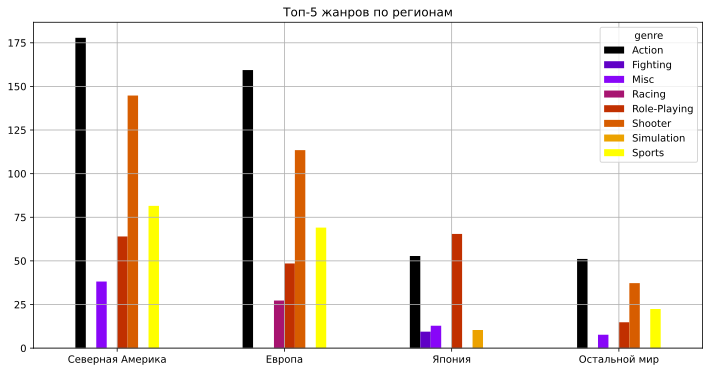

In [74]:
pivot_popular_genres.T.plot(kind='bar',figsize=(12,6),colormap='gnuplot')
plt.title('Топ-5 жанров по регионам')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [75]:
for_visual_genres = df_act.pivot_table(values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], index='genre', aggfunc='sum')
for_visual_genres.columns = ["Европа", "Япония", "Северная Америка", "Остальной мир"]
for_visual_genres

Европа  Япония  Северная Америка  Остальной мир
genre                                                        
Action        159.34   52.80            177.84          51.14
Adventure       9.46    8.24              8.92           2.81
Fighting       10.79    9.44             19.79           4.47
Misc           26.32   12.86             38.19           7.67
Platform       21.41    8.63             25.38           5.58
Puzzle          1.40    2.14              1.13           0.22
Racing         27.29    2.50             17.22           6.49
Role-Playing   48.53   65.44             64.00          14.83
Shooter       113.47    9.23            144.77          37.26
Simulation     14.55   10.41              7.97           2.19
Sports         69.09    8.01             81.53          22.44
Strategy        5.17    2.88              4.23           1.06

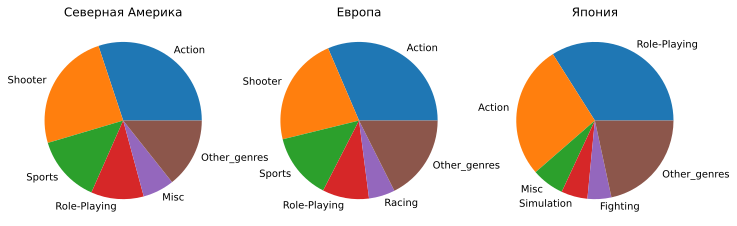

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

for i in range(3):
    #5 самых продающих платформ
    df_i = (df_act.groupby('genre')[list(regions.values())[i]].sum().
            reset_index().
            sort_values(list(regions.values())[i], ascending=False, ignore_index=True).
            head(5))
    #остальные продажи занесем в Other_platforms
    df_i = df_i.append({'genre': 'Other_genres', list(regions.values())[i]: 
                        df_act[list(regions.values())[i]].sum() - df_i[list(regions.values())[i]].sum()},
                       ignore_index=True)
    ax[i].pie(df_i[list(regions.values())[i]], labels = df_i['genre'])
    
    ax[i].set_title(list(regions.keys())[i])

plt.show();

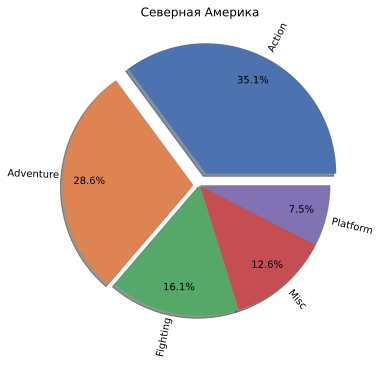

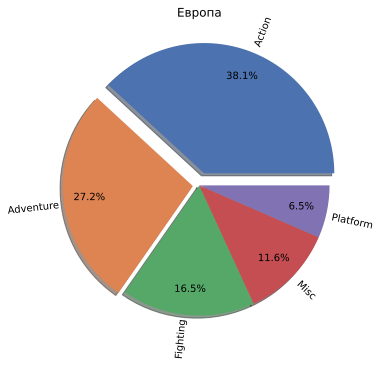

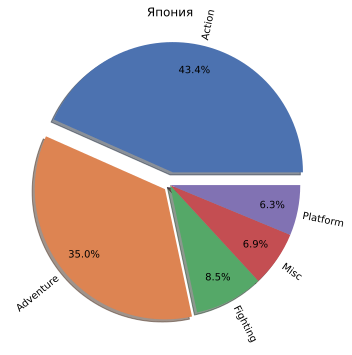

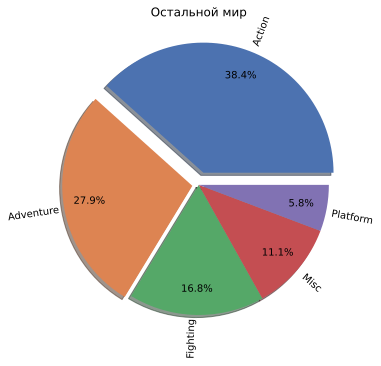

In [90]:
regions_analyzed = pivot_popular_genres.columns.to_list()
for region in regions_analyzed:
    fig, ax = plt.subplots(figsize=(12, 6))
    data = for_visual_genres[region].sort_values(ascending=False)[:5]
    labels = for_visual_genres.index.to_list()[:5]
    colors = sns.color_palette('deep')
    explode=[0.1, 0.05, 0, 0, 0]
    

    plt.pie(data, labels=labels, colors=colors,
            labeldistance=1.03,
            rotatelabels=True,
            explode=explode,
            autopct='%.1f%%',
            pctdistance=0.8, 
            shadow=True)
    plt.title(region)
    plt.show();

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [78]:
pivot_rating = df_act.pivot_table(index='rating',
                                  values=list(regions.values()),
                                  aggfunc='sum')
pivot_rating

eu_sales  jp_sales  na_sales  other_sales
rating                                           
-1         91.50    108.84    103.31        27.17
E         113.03     28.33    114.37        31.44
E10+       55.37      8.19     75.70        16.23
M         193.96     21.20    231.57        63.38
T          52.96     26.02     66.02        17.94

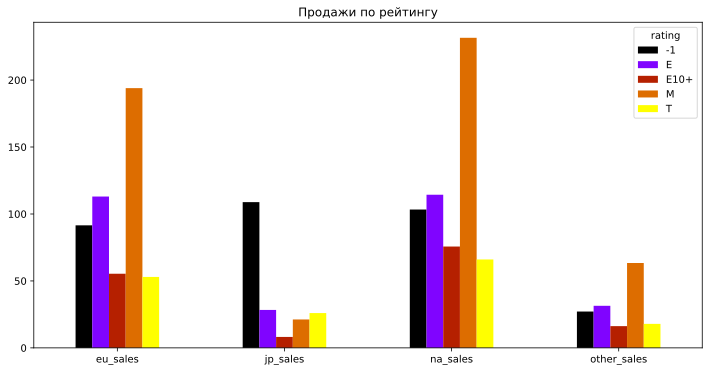

In [79]:
pivot_rating.T.plot(kind='bar',figsize=(12,6),colormap='gnuplot')
plt.title('Продажи по рейтингу')
plt.xticks(rotation=0)
plt.show()

In [80]:
def rating_categorizer(rate): #категоризируем значения рейтинга
    if rate['rating'] == "E":
        return 1
    if rate['rating'] == "E10+":
        return 2
    if rate['rating'] == "EC":
        return 3
    if rate['rating'] == "M":
        return 4
    if rate['rating'] == "RP":
        return 5
    if rate['rating'] == "T":
        return 6
    return 0

In [81]:
df_act['rating_int'] = df_act.apply(rating_categorizer, axis=1)
df_act

name platform  year_of_release         genre  \
0                Grand Theft Auto V      PS3             2013        Action   
1                Grand Theft Auto V     X360             2013        Action   
2         Call of Duty: Black Ops 3      PS4             2015       Shooter   
3               Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
4        Call of Duty: Black Ops II      PS3             2012       Shooter   
...                             ...      ...              ...           ...   
2881               Strawberry Nauts      PSV             2016     Adventure   
2882               Aiyoku no Eustia      PSV             2014          Misc   
2883  Samurai Warriors: Sanada Maru      PS3             2016        Action   
2884        Haitaka no Psychedelica      PSV             2016     Adventure   
2885            Winning Post 8 2016      PSV             2016    Simulation   

      na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0         7.02      9.09      0.98         3.96            97          82   
1         9.66      5.14      0.06         1.41            97          81   
2         6.03      5.86      0.36         2.38            -1         -10   
3         5.28      4.19      4.35         0.78            -1         -10   
4         4.99      5.73      0.65         2.42            83          53   
...        ...       ...       ...          ...           ...         ...   
2881      0.00      0.00      0.01         0.00            -1         -10   
2882      0.00      0.00      0.01         0.00            -1         -10   
2883      0.00      0.00      0.01         0.00            -1         -10   
2884      0.00      0.00      0.01         0.00            -1         -10   
2885      0.00      0.00      0.01         0.00            -1         -10   

     rating  total_sales  rating_int  
0         M        21.05           4  
1         M        16.27           4  
2        -1        14.63           0  
3        -1        14.60           0  
4         M        13.79           4  
...     ...          ...         ...  
2881     -1         0.01           0  
2882     -1         0.01           0  
2883     -1         0.01           0  
2884     -1         0.01           0  
2885     -1         0.01           0  

[2886 rows x 13 columns]

In [82]:
df_act.corr()

year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.092848 -0.053163 -0.063587    -0.057375   
na_sales               -0.092848  1.000000  0.767484  0.271010     0.792277   
eu_sales               -0.053163  0.767484  1.000000  0.265134     0.936906   
jp_sales               -0.063587  0.271010  0.265134  1.000000     0.203078   
other_sales            -0.057375  0.792277  0.936906  0.203078     1.000000   
critic_score           -0.053779  0.257595  0.251616 -0.014495     0.244013   
user_score             -0.016853  0.195842  0.183058 -0.032480     0.180546   
total_sales            -0.083488  0.920981  0.927487  0.450363     0.909525   
rating_int              0.018355  0.129687  0.110842 -0.051658     0.123105   

                 critic_score  user_score  total_sales  rating_int  
year_of_release     -0.053779   -0.016853    -0.083488    0.018355  
na_sales             0.257595    0.195842     0.920981    0.129687  
eu_sales             0.251616    0.183058     0.927487    0.110842  
jp_sales            -0.014495   -0.032480     0.450363   -0.051658  
other_sales          0.244013    0.180546     0.909525    0.123105  
critic_score         1.000000    0.841101     0.248010    0.619820  
user_score           0.841101    1.000000     0.180417    0.721080  
total_sales          0.248010    0.180417     1.000000    0.109910  
rating_int           0.619820    0.721080     0.109910    1.000000

### Вывод

Отвечая на запросы заказчика, можем заключить следующее:  

Для всех регионов, кроме Японии - самыми популярными платформами являются *PS3, Xbox 360 и Nintendo Wii*. Для японских же геймеров гораздо более привлектальны стандартные консоли *Nintendo - DS и 3DS, PS3* же занимает 3 место. Примечательно также, что на 4 месте у японцев оказалась *PSP*, которая для пользователей остального мира не только не вошла в первую пятерку, но и заняла везде почти последние места. Это говорит о разительных отличиях вкусов японских геймеров касательно платформ.   

Также в Японии почти не играют в *Xbox 360* и вообще не играют на *ПК*. В Европе же *ПК* как платформа входит в первую пятерку, в Америке также на *ПК* играют, но меньше.  

Что касатеся жанров, то абсолютным лидером во всем мире (конечно, снова за исключением Японии, там он на 2 месте) является жанр *Action*. Серебро и бронзу также во всем мире, кроме Японии разделили *Shooter и Sports*. Японцы же предпочитают ему *RPG*, не будем их за это осуждать.  

Согласно анализу медианных продаж довольно большую долю занимает также жанр *platform*.

Никакой зависимости объема продаж от рейтинга обнуражено не было.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотеза $H^0$: Средние пользовательские рейтинги платформ Xbox One и PC равны  
Гипотеза $H^1$: Средние пользовательские рейтинги платформ Xbox One и PC не равны

In [83]:
xbox_one_sample = df_act.query('platform == "XOne" and user_score > 0')['user_score']
pc_sample = df_act.query('platform == "PC" and user_score > 0')['user_score']

alpha = .05

results = st.ttest_ind(xbox_one_sample, pc_sample)

print('P-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Средние пользовательские рейтинги платформ Xbox One и PC не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Средние пользовательские рейтинги платформ Xbox One и PC равны')

P-значение = 0.5535080500643805
Не получилось отвергнуть нулевую гипотезу
Средние пользовательские рейтинги платформ Xbox One и PC равны


In [84]:
# Комментарий ревьюера
xbox_one_sample.min()

16

### Средние пользовательские рейтинги жанров Action и Sports разные

Гипотеза $H^0$: Средние пользовательские рейтинги жанров Action и Sports равны  
Гипотеза $H^1$: Средние пользовательские рейтинги жанров Action и Sports не равны

In [85]:
action_sample = df_act.query('genre == "Action" and user_score > 0')['user_score']
sports_sample = df_act.query('genre == "Sports" and user_score > 0')['user_score']

alpha = .01

results = st.ttest_ind(action_sample, sports_sample)

print('P-значение =', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
    print("Средние пользовательские рейтинги жанров Action и Sports не равны")
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print("Средние пользовательские рейтинги жанров Action и Sports равны")

P-значение = 3.7163089460930885e-26
Отвергаем нулевую гипотезу
Средние пользовательские рейтинги жанров Action и Sports не равны


### Вывод

Мы проверили две гипотезы и можем сделать следующее экспертное заключение:   

1. Геймеры примерно одинаково оценивают игры на компьютере и на Xbox One. 
2. Спортивные игры и экшен - оцениваются игроками не одинаково.   

**Пояснения:**  
1. Для проверки гипотез был применен t-test. В первом тесте критический уровень значимости был задан *0.05*. Нулевую гипотезу согласно результатам теста мы отвергнуть не смогли. 
2. Во втором тесте уровень значимости был задан *0.01*. P-value получился меньше одной тысячной. Это значит что вероятность получить различие в 1% случайно - крррайне мала. А значит геймеры не одинаково ценят жанры экшена и спорта. 

## Вывод

**В ходе проекта** были изучены и обработаны данные по продажам игр, начиная с 1980х годов:

* обработаны пропуски/изменен регистр названий колонок/изменен тип данных
* рассчитан общий объем продаж каждой игры
* установлено сокращение количеста выпускаемых игр и продаж за последнией 10 лет
* определена скорость устаревания платформ, в прошлом платформы устаревали за 4-7 лет, современные платформы существуют дольше, до 10 лет
* определены самые прибыльные платформы за все время - PS2, X360, PS3, Wii и DS
* на текущий момент существуют две доминирующие консоли - Xbox One от Microsoft и Playstation 4 от Sony. 
* установлено, что рейтинг пользователей почти не коррелирует с продажами
* исследованы предпочтения игроков из трех разных регионов. Вкусы игроков из Северной Америки идентичны Европейским, предпочитают почти что одинаковые жанры, немного разнятся по популярности ведущие платформы. Например, в Европе больше предпочтений отдают PS, нежели XBox. Япония выделяется любовью к портативным консолям, там до сих пор много играют в PSP. 
* изучены жанровые препочтения игроков. Топ-5 любимых жанров в Северной Америке и Европе похожи, за исключением одной позиции (action, shooter, sports, role-playing).В Японии больше всего любят RPG.
* проверены две гипотезы, установлено, что:  
1. Средние пользовательские рейтинги XBox One и PC равны,
2. Средние пользовательские рейтинги жанров ACtion и Sports разные

**Рекомендации:**

Для разных регионов нужно выбирать разную стратегию для построения рекламных кампаний. Так как предпочтения пользователей, например, в Америке и Японии имеют значительные отличия. Начиная от выбора платформы, заканчивая жанрами.

Тем не менее, попробуем собрать факторы, которые помогут определить будет ли игра успешной в коммерчеком плане. В ближайшем году нужно сфокусироваться на самых актуальных платформах - X-Box One, PS4 и 3DS. Самые популярные жанры - Action, Shooter, Sports и Role-Playing в Японии. Предпочтение следует отдавать играм с рейтингом M и высоким рейтингом критиков, такие игры чаще становятся кассовыми.  

При анализе корреляции между оценками и продажами было выяснено, оценки пользователей вообще не коррелируют с продажами, а оценки критиков лишь на 0.4, что также является недостаточным для составления рекламной кампании.

Из года в год самыми популярными жанрами остаются игры в жанрах Action, Shooter и RPG.  

Основное направление рекламных кампаний стоит строить вокруг популярных платформ: X-Box One, PS4 - в Европе и Северной Америке, Nintendo - в Японии.

Игры с рейтингом, присваиваемым организацией ESRB, имеют свойство больше продаваться (помимо игр *для всех*) с маркером *для взрослых* категории **М**. Отдельно можно направить таргетированную рекламу на взрослую аудиторию. 

☔☔☔